In [3]:
!pip install einops
!pip install torchmetrics
import einops
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
from torchvision import transforms
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [30]:
# This code was initially written in Colab so I stored the dataset in my Google Drive. If accessing dataset locally, please comment out the below code
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CIFAR-10 Dataset

The CIFAR-10 Dataset contains 60,000 32x32 RBG images in 10 classes. The unpickle function allows us to access the dataset as a dictionary.

In [31]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [32]:
data_meta = unpickle('/content/drive/MyDrive/cifar-10-batches-py/batches.meta')
print(data_meta[b'label_names'])


[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


# Reshape of Data

Before we begin training our model, we want to change the shape of our data so we can apply convolutions more easily. Let's begin by changing the shape of our inputs. The CIFAR dataset page says:

> a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

We want to change the data such that it has the shape (image_count=10000, RGB_channel=3, height=32, width=32).

In [33]:
def adjustShapeForConv(batch):

    # our model takes in dtype=torch.float so
    batch[b'data'] = torch.tensor(batch[b'data'], dtype=torch.float)
    batch[b'labels'] = torch.tensor(batch[b'labels'])

    # We need to change our data slightly to comply with pytorch's conv2d function
    # Separate the red, green, and blue channels
    red, green, blue = torch.split(batch[b'data'], 1024, dim=-1)
    rbg_shape = (10000, 32, 32)
    red, green, blue = red.view(rbg_shape), green.view(rbg_shape), blue.view(rbg_shape)

    # Recombine in format suitable for convolution
    batch[b'data'] = torch.stack((red, green, blue), dim=3)
    batch[b'data'] = einops.rearrange(batch[b'data'], 'N h w RGB -> N RGB h w')


In [34]:
# load the data

train_batches = [
    unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_1'),
    unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_2'),
    unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_3'),
    unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_4'),
    unpickle('/content/drive/MyDrive/cifar-10-batches-py/data_batch_5')]

test_batch = unpickle('/content/drive/MyDrive/cifar-10-batches-py/test_batch')

for batch in train_batches:
    adjustShapeForConv(batch)

adjustShapeForConv(test_batch)

# data_batch_1[b'data'].shape == (10000, 3, 32, 32)

# Visualizing the Data

In [35]:
def showData(batch, data_meta):
    # Convert data to pytorch tensors
    sample_data = batch[b'data'].permute(0, 2, 3, 1).type(torch.uint8)
    sample_labels = batch[b'labels']
    # imgs.shape == (10000, 32, 32, 3), where the last dim contains the RGB value

    fig = plt.figure(figsize=(10, 4))
    rows = 2
    columns = 5
    for i in range(10):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(sample_data[i], interpolation='nearest')
        plt.axis('off')
        plt.title(data_meta[b'label_names'][sample_labels[i]].decode('utf-8'))
    plt.show()

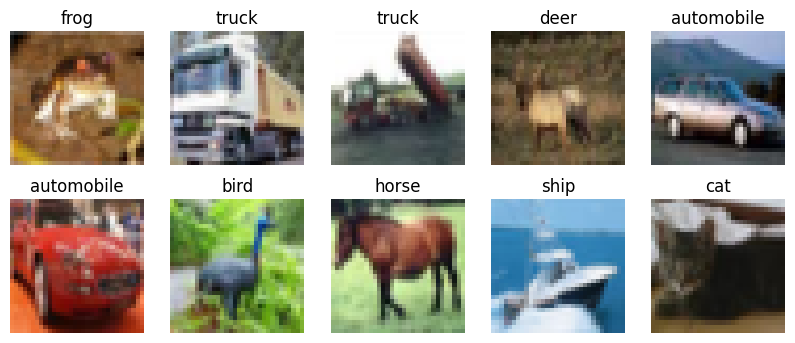

In [36]:
showData(train_batches[0], data_meta)

# Why We Use Convolutional Neural Network Over a Traditional MLP

Our images are 32x32 arrays that could be flattened into 1024x1 vectors and fed into an MLP. This approach does not work on relatively complex images because by flattening the image, we fail to capture spatial dependencies in the images. CNNs, on the other hand, do capture spatial dependencies!

In [37]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1    = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1      = nn.BatchNorm2d(32)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.conv2    = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2      = nn.BatchNorm2d(64)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.pool1    = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3    = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3      = nn.BatchNorm2d(128)
        self.relu3    = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.conv4    = nn.Conv2d(128, 196, 3, padding=1)
        self.bn4      = nn.BatchNorm2d(196)
        self.relu4    = nn.ReLU()
        self.dropout4 = nn.Dropout(0.1)
        self.pool2    = nn.MaxPool2d(2, 2)

        self.conv5    = nn.Conv2d(196, 256, 3, padding=1)
        self.bn5      = nn.BatchNorm2d(256)
        self.relu5    = nn.ReLU()
        self.dropout5 = nn.Dropout(0.1)
        self.conv6    = nn.Conv2d(256, 384, 3, padding=1)
        self.bn6      = nn.BatchNorm2d(384)
        self.relu6    = nn.ReLU()
        self.dropout6 = nn.Dropout(0.1)
        self.pool3    = nn.MaxPool2d(2, 2)

        self.flatten  = nn.Flatten()
        self.dropout7 = nn.Dropout(0.5)
        self.fc1      = nn.Linear(in_features=6144, out_features=512)
        self.bn7      = nn.BatchNorm1d(512)
        self.relu7    = nn.ReLU()
        self.dropout8 = nn.Dropout(0.5)
        self.fc2      = nn.Linear(in_features=512, out_features=128)
        self.bn8      = nn.BatchNorm1d(128)
        self.relu8    = nn.ReLU()
        self.fc3      = nn.Linear(in_features=128, out_features=10)

        # Initialize weights using Xavier (Glorot) Uniform initialization
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        x = self.pool1(self.dropout2(self.relu2(self.bn2(self.conv2(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))))))

        x = self.pool2(self.dropout4(self.relu4(self.bn4(self.conv4(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))))))

        x = self.pool3(self.dropout6(self.relu6(self.bn6(self.conv6(self.dropout5(self.relu5(self.bn5(self.conv5(x)))))))))

        x = self.fc3(self.relu8(self.bn8(self.fc2(self.dropout8(self.relu7(self.bn7(self.fc1(self.dropout7(self.flatten(x))))))))))

        return x

# Data Augmentation

## Vertically Mirroring Images to Increase Training Data Size

We will augment our data by mirror all training images so we have twice as much data to train on! We can apply vertical mirror transformations on our data because it makes sense intuitively for a car/frog to either be facing left or right. We can't, however, rotate our images or horizontally mirror our images because such images wouldn't exist in real life (e.g. we don't see upside-down frogs or trucks that often!).

In [38]:
for i in range(5):
    new_batch = train_batches[i].copy()
    new_batch[b'data'] = torch.flip(new_batch[b'data'], (-1,))
    train_batches.append(new_batch)

We now have 10 batches of training data (100,000 total images)! Then, we will combine all our train data into one tensor so we can easily batch while training.

In [39]:
for i, batch in enumerate(train_batches):
    if i == 0:
        train_data = batch[b'data']
        train_labels = batch[b'labels']
    else:
        train_data = torch.cat((train_data, batch[b'data']), 0)
        train_labels = torch.cat((train_labels, batch[b'labels']), 0)

# Convert to float since our model only accepts floats
train_data.float()

print(train_data.shape)
print(train_labels.shape)

torch.Size([100000, 3, 32, 32])
torch.Size([100000])


In [40]:
test_data = test_batch[b'data'].float()
test_labels = test_batch[b'labels']

print(test_data.shape)
print(test_labels.shape)

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


## Data Normalization

Next, We will normalize each pixel across each channel so that any one pixel from a specific channel does not disproportionately affect the model training.

In [41]:
def calculateMeanAndStd(batches):
    means = torch.zeros([len(batches), 3])
    vars  = torch.zeros([len(batches), 3])
    std = torch.zeros(3)
    batch_size = batches[0][b'data'].shape[0] # batch_size == 10000

    for i, batch in enumerate(batches):
        means[i] = batch[b'data'].mean([0, 2, 3])
        vars[i]  = batch[b'data'].var([0, 2, 3])

    mean = means.sum(dim=0) / len(batches)

    for i in range(len(batches)):
        std += (batch_size - 1) * vars[i] + batch_size * ((means[i] - mean) ** 2)
    std = (std / (len(batches) * batch_size)) ** 0.5
    return mean, std

train_mean, train_std = calculateMeanAndStd(train_batches)
test_mean, test_std = calculateMeanAndStd([test_batch])

print('Train Mean:', train_mean)
print('Train Standard Deviation:', train_std)
print('Test Mean:', test_mean)
print('Test Standard Deviation:', test_std)

Train Mean: tensor([125.3069, 122.9504, 113.8654])
Train Standard Deviation: tensor([62.9901, 62.0856, 66.7016])
Test Mean: tensor([126.0247, 123.7085, 114.8543])
Test Standard Deviation: tensor([62.8932, 61.9344, 66.7027])


In [42]:
# Normalizing Step

train_data = (train_data - train_mean.view(3, 1, 1)) / train_std.view(3, 1, 1)
test_data = (test_data - test_mean.view(3, 1, 1)) / test_std.view(3, 1, 1)

# Cross Entropy Loss

Cross-entropy loss (AKA log loss) measures how 'inaccurate' a model is. It is used for models that output probability values. Our model is trying to classify images and for a given image, it assigns the probability the image is a member of a certain class.

![Graph of cross entropy loss when the label is true](cross_entropy.webp)

Notably, cross-entropy loss penalizes severely for predictions that are confident and wrong.

# Stochastic Gradient Descent

Stochastic Gradient Descent (SGD) is an optimization algorithm used to update the parameters of a machine learning model to reduce loss. SGD implements the following updating algorithm:

$$\theta_i = \theta_i - \alpha \frac{\partial L}{\partial \theta_i}$$

We often add a momentum term, which additionally modifies the weights by keeping an exponentially weighted moving average. The momentum term, essentially adds weightage to past values of the gradient. Empirically, this leads to quicker convergence on a minimum.

In [43]:
model = CNN()
total_params = sum(p.numel() for p in model.parameters())
print("Number of model parameters:", total_params)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

Number of model parameters: 4872790


# Using GPU

In [44]:
!nvidia-smi

Wed Oct 11 22:40:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |  12079MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
train_data = train_data.cuda()
train_labels = train_labels.cuda()
test_data = test_data.cuda()
test_labels = test_labels.cuda()

model.cuda()

acc_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).cuda()

# Training and Testing

In [47]:
EPOCHS = 50
BATCH_SIZE = 64
NUM_OF_TRAIN_SAMPLES = train_data.shape[0] # 10 * 10000
NUM_OF_TRAIN_BATCHES = (NUM_OF_TRAIN_SAMPLES + BATCH_SIZE - 1) // BATCH_SIZE
NUM_OF_TEST_SAMPLES = test_data.shape[0]
loss_train_history = []
accuracy_train_history = []
loss_test_history = []
accuracy_test_history = []

for epoch in range(EPOCHS):
    accuracy_train_epoch = 0.0
    loss_train_epoch = 0.0

    for i in range(NUM_OF_TRAIN_BATCHES):

        # Slice our dataset into batches of size BATCH_SIZE
        start_idx = i * BATCH_SIZE
        end_idx = min((i + 1) * BATCH_SIZE, NUM_OF_TRAIN_SAMPLES)
        X = train_data[start_idx : end_idx]
        Y = train_labels[start_idx : end_idx]

        # Get the model predictions
        Y_pred = model(X)

        # Calculate loss
        loss = loss_fn(Y_pred, Y)

        # Zero out the gradient
        optimizer.zero_grad()

        # Get gradients through backprop
        loss.backward()

        # We multiply by batch size since we will ultimately divide by total training samples. This gives us average loss per epoch
        loss_train_epoch += loss.item() * BATCH_SIZE

        # Calculate number of correct predictions
        accuracy_train_epoch += acc_metric(Y_pred, Y).float() * BATCH_SIZE

        # Update parameters of model
        optimizer.step()

    accuracy_train_epoch /= NUM_OF_TRAIN_SAMPLES
    accuracy_train_history.append(accuracy_train_epoch)
    loss_train_epoch /= NUM_OF_TRAIN_SAMPLES
    loss_train_history.append(loss_train_epoch)
    print(f'Train Metrics Epoch {epoch} Loss {loss_train_epoch:.4f} Accuracy {accuracy_train_epoch:.4f}')

    loss_test_epoch = 0.0
    accuracy_test_epoch = 0.0

    # No need to keep track of gradients while evaluating the model
    with torch.no_grad():
        X = test_data
        Y = test_labels

        # Calculate model predictions
        Y_pred = model(X)

        # Calculate loss
        loss = loss_fn(Y_pred, Y)

        loss_test_history.append(loss.item())

        # Get the accuracy
        accuracy_test_epoch = acc_metric(Y_pred, Y).float()
        accuracy_test_history.append(accuracy_test_epoch)

        print(f'Test Metrics Epoch {epoch} Loss {loss:.4f} Accuracy {accuracy_test_epoch:.4f}')

Train Metrics Epoch 0 Loss 1.6132 Accuracy 0.4108
Test Metrics Epoch 0 Loss 1.2995 Accuracy 0.5316
Train Metrics Epoch 1 Loss 1.1836 Accuracy 0.5789
Test Metrics Epoch 1 Loss 1.0356 Accuracy 0.6321
Train Metrics Epoch 2 Loss 0.9830 Accuracy 0.6583
Test Metrics Epoch 2 Loss 0.8805 Accuracy 0.6962
Train Metrics Epoch 3 Loss 0.8408 Accuracy 0.7127
Test Metrics Epoch 3 Loss 0.7769 Accuracy 0.7350
Train Metrics Epoch 4 Loss 0.7413 Accuracy 0.7500
Test Metrics Epoch 4 Loss 0.6896 Accuracy 0.7688
Train Metrics Epoch 5 Loss 0.6619 Accuracy 0.7805
Test Metrics Epoch 5 Loss 0.6369 Accuracy 0.7871
Train Metrics Epoch 6 Loss 0.6018 Accuracy 0.8042
Test Metrics Epoch 6 Loss 0.5890 Accuracy 0.8097
Train Metrics Epoch 7 Loss 0.5447 Accuracy 0.8255
Test Metrics Epoch 7 Loss 0.5611 Accuracy 0.8169
Train Metrics Epoch 8 Loss 0.4983 Accuracy 0.8422
Test Metrics Epoch 8 Loss 0.5195 Accuracy 0.8343
Train Metrics Epoch 9 Loss 0.4618 Accuracy 0.8563
Test Metrics Epoch 9 Loss 0.5069 Accuracy 0.8349
Train Metr

# Pushing Test Accuracy Up!

2. After adding dropout, test 80%, train 78%
3. After increasing batch size from 16 to 32, test 82.5%, train 82.5% in 4 mins
4. with 64 batch size, test 82.3%, train 82.5% in 3 mins
5. After increasing width of convolutional layers, test 83.5%, train 85% in 6 mins

Now that we have augmented our CNN, we can try training it for 50 epochs. After 50 epochs, we get train accuracy of 94% and test accuracy 88%!

# Test and Training Accuracy & Loss Graphs

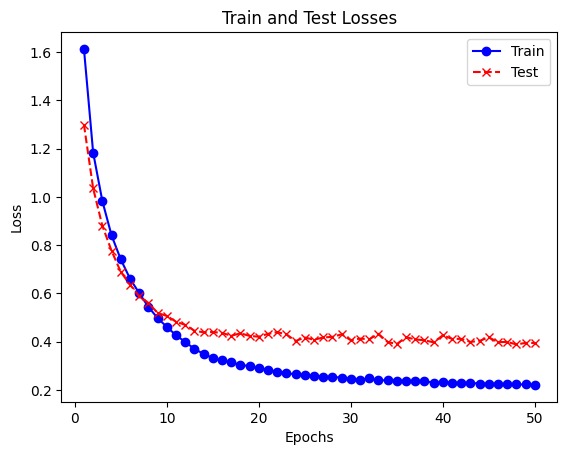

In [48]:
x = torch.arange(1, EPOCHS + 1)

plt.plot(x, loss_train_history, label='Train', color='blue', linestyle='-', marker='o')

plt.plot(x, loss_test_history, label='Test', color='red', linestyle='--', marker='x')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

# Display the plot
plt.show()

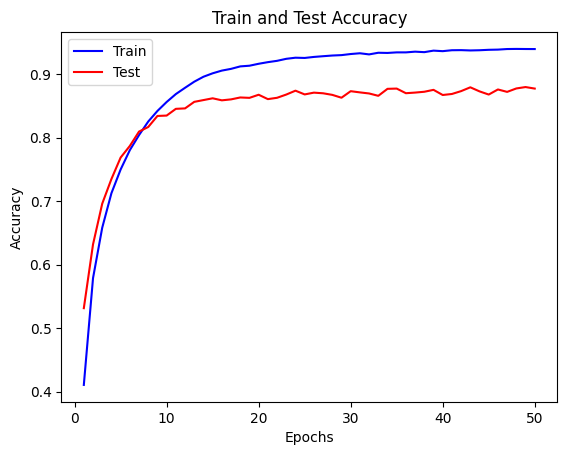

In [55]:
x = torch.arange(1, EPOCHS + 1)
train_acc = []
test_acc = []
for i, acc in enumerate(accuracy_train_history):
    train_acc.append(acc.to("cpu"))

for i, acc in enumerate(accuracy_test_history):
    test_acc.append(acc.to("cpu"))

plt.plot(x, train_acc, label='Train', color='blue', linestyle='-')

plt.plot(x, test_acc, label='Test', color='red', linestyle='-')

# Add labels and a legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy')
plt.legend()

# Display the plot
plt.show()